In [1]:
# 필요한 module을 불러오기

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# Image Dataset을 저장할 경로 변수 정의
path2data = "./data"

# 만약 Directory가 존재하지 않는다면 생성한다
if not os.path.exists(path2data):
  os.mkdir(path2data)

# Dataset을 Load하기
train_ds = datasets.STL10(path2data, split="train", download=True, transform = transforms.ToTensor())
val_ds = datasets.STL10(path2data, split="test", download=True, transform = transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [3]:
# DataLoader에서 data를 추출할 때 사용할 preprocessor를 정의한다
transformation = transforms.Compose([
                      transforms.ToTensor(), # 픽셀을 0-1사이 값으로 정규화하고 Tensor Type변환 한다
                      transforms.Resize(299) # 3*299*299으로 변환한다
])

train_ds.transform = transformation
val_ds.transform = transformation

In [4]:
# Dataset을 Batch_size단위로 가져올 DataLoader를 정의한다
train_dl = DataLoader(train_ds, batch_size=8, shuffle = True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle = True)


In [25]:
# 본격적으로 Inception-ResNet v2 모델을 구축해보자
# Inception-v4 module에 Skip-connection이 적용된 모듈을 사용한다

# 모든 Convolutional Layer에 Batch normalization과 ReLU를 일괄적으로 적용하기 위해
# 다음과 같은 Block을 정의하였다.
class BasicConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  
  def forward(self, x):
    x = self.conv(x)
    return x

# Inception-ResNetv2 모델의 Architecture중 한 부분인 stem을 정의한다
class Stem(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        BasicConv2d(3,32,3,stride=2, padding=0), # output : 32*149*149
        BasicConv2d(32,32,3, stride=1, padding=0), # output : 32*147*147
        BasicConv2d(32,64,3, stride=1, padding=1) # output : 64*147*147
    )

    # branch를 만나면 결과를 concatenate하여 다음 layer로 전달한다
    self.branch3x3_conv = BasicConv2d(64, 96, 3, stride=2, padding=0) # output : 96*73*73
    self.branch3x3_pool = nn.MaxPool2d(4, stride=2, padding=1) # output : 64*73*73

    self.branch7x7a = nn.Sequential(
        BasicConv2d(160, 64, 1, stride=1, padding=0),
        BasicConv2d(64, 96, 3, stride=1, padding=0)
    ) # output : 96*71*71

    self.branch7x7b = nn.Sequential(
        BasicConv2d(160, 64, 1, stride=1, padding=0),
        BasicConv2d(64, 64, (7,1), stride=1, padding=(3,0)),
        BasicConv2d(64, 64, (1,7), stride=1, padding=(0,3)),
        BasicConv2d(64, 96, 3, stride=1, padding=0)
    ) # output : 96*71*71

    self.branchpoola = BasicConv2d(192, 192, 3, stride=2, padding=0) # output : 192*35*35
    self.branchpoolb = nn.MaxPool2d(kernel_size=4, stride=2, padding=1) # output : 192*35*35

  def forward(self, x):
    x = self.conv1(x)
    x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1)
    x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)), dim=1)
    x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
    return x

# Inception-ResNetv2 모델의 Architecture중 한 부분인
# skip-connection이 적용된 Inceptionv4 Block-A을 정의한다
class Inception_Resnet_A(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.branch1x1 = BasicConv2d(in_channels, 32, 1, stride=1, padding=0)

    self.branch3x3 = nn.Sequential(
        BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
        BasicConv2d(32, 32, 3, stride=1, padding=1)
    )

    self.branch3x3stack = nn.Sequential(
        BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
        BasicConv2d(32, 48, 3, stride=1, padding=1),
        BasicConv2d(48, 64, 3, stride=1, padding=1)
    )
    #branch 1,2,3에서 나온 채널을 concatenate한 후에 W, H를 줄여주고 channel을 늘려준다
    self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
    
    # skip-connection 구현
    self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
    self.bn = nn.BatchNorm2d(384)
    self.relu = nn.ReLU()

  def forward(self, x):
    x_shortcut = self.shortcut(x)
    # 출력형태는 모두 (batch_size, channel, height, width 이다)
    x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
    x = self.reduction1x1(x)
    x = self.bn(x_shortcut  + x)
    x = self.relu(x)
    return x

# Inception-ResNetv2 모델의 Architecture중 한 부분인
# skip-connection이 적용된 Inceptionv4 Block-B를 정의한다
class Inception_Resnet_B(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.branch1x1 = BasicConv2d(in_channels, 192,1, stride=1, padding=0,)
    self.branch7x7 = nn.Sequential(
        BasicConv2d(in_channels, 128, 1, stride=1, padding=0),
        BasicConv2d(128,160,(1,7), stride=1, padding=(0,3)),
        BasicConv2d(160,192,(7,1), stride=1, padding=(3,0))
    )

    self.reduction1x1 = nn.Conv2d(384, 1152, 1, stride=1, padding=0)
    self.shortcut = nn.Conv2d(in_channels, 1152,1, stride=1, padding=0)
    self.bn = nn.BatchNorm2d(1152)
    self.relu = nn.ReLU()

  def forward(self, x):
    x_shortcut = self.shortcut(x)
    x = torch.cat((self.branch1x1(x), self.branch7x7(x)), dim=1)
    x = self.reduction1x1(x) * 0.1
    x = self.bn(x + x_shortcut)
    x = self.relu(x)
    return x

# Inception-ResNetv2 모델의 Architecture중 한 부분인
# skip-connection이 적용된 Inceptionv4 Block-C를 정의한다
class Inception_Resnet_C(nn.Module):
  def __init__(self, in_channels):
    super().__init__()
    
    self.branch1x1 = BasicConv2d(in_channels, 192,1,stride=1, padding=0)
    self.branch3x3 = nn.Sequential(
        BasicConv2d(in_channels, 192, 1, stride=1, padding=0),
        BasicConv2d(192,224,(1,3), stride=1, padding=(0,1)),
        BasicConv2d(224,256,(3,1), stride=1, padding=(1,0))
    )

    self.reduction1x1 = nn.Conv2d(448,2144,1,stride=1, padding=0)
    self.shortcut = nn.Conv2d(in_channels, 2144, 1, stride=1, padding=0)
    self.bn = nn.BatchNorm2d(2144)
    self.relu = nn.ReLU()

  def forward(self, x):
    x_shortcut = self.shortcut(x)
    x = torch.cat((self.branch1x1(x), self.branch3x3(x)), dim=1)
    x = self.reduction1x1(x) * 0.1
    x = self.bn(x_shortcut + x)
    x = self.relu(x)
    return x


# Inception-ResNetv2 모델의 Architecture중 한 부분인
# Reduction-A Module을 정의한다
# Reduction-A와 B모듈을 통과하면 채널 수가 바뀌어 출력된다
class ReductionA(nn.Module):
  def __init__(self, in_channels, k,l,m,n):
    super().__init__()
    self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)
    self.branch3x3 = BasicConv2d(in_channels, n, 3, stride=2, padding=0)
    self.branch3x3stack = nn.Sequential(
        BasicConv2d(in_channels,k,1,stride=1, padding=0),
        BasicConv2d(k,l,3,stride=1, padding=1),
        BasicConv2d(l,m,3,stride=2, padding=0)
    )
    self.output_channels = in_channels + n + m

  def forward(self, x):
    x = torch.cat((self.branchpool(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
    return x

# Inception-ResNetv2 모델의 Architecture중 한 부분인
# Reduction-B Module을 정의한다
class ReductionB(nn.Module):
  def __init__(self, in_channels):
    super().__init__()

    self.branchpool = nn.MaxPool2d(kernel_size=3, stride=2)
    self.branch3x3a = nn.Sequential(
        BasicConv2d(in_channels, 256,1,stride=1, padding=0),
        BasicConv2d(256,384,3, stride=2, padding=0)
    )
    self.branch3x3b = nn.Sequential(
      BasicConv2d(in_channels, 256,1,stride=1, padding=0),
      BasicConv2d(256,288,3, stride=2, padding=0)
    )
    self.branch3x3stack = nn.Sequential(
        BasicConv2d(in_channels,256,1,stride=1, padding=0),
        BasicConv2d(256,288,3,stride=1, padding=1),
        BasicConv2d(288,320,3,stride=2, padding=0)
    )

  def forward(self, x):
    x = torch.cat((self.branchpool(x), self.branch3x3a(x), self.branch3x3b(x),self.branch3x3stack(x)), dim=1)
    return x

# Inception-ResNetv2를 구성하는 모듈들의 정의가 모두 완료되었다.
# 본격적으로 모델을 구성해보자

class InceptionResNetV2(nn.Module):
  # A,B,C는 Inception_Resnet_A,B,C를 각각 몇 번을 쌓아올릴 것인지 결정하기 위한 인자이다
  # k,l,m,n은 Reduction-A 모듈에서 중간 및 최종 출력채널 수를 결정하기 위한 Parameter이다
  def __init__(self, A, B, C, k=256, l=256, m=384, n=384, num_classes=10, init_weights=True):
    super().__init__()
    blocks = []
    blocks.append(Stem())
    for i in range(A):
      blocks.append(Inception_Resnet_A(384))
    blocks.append(ReductionA(384,k,l,m,n))
    
    for i in range(B):
      blocks.append(Inception_Resnet_B(1152))
    blocks.append(ReductionB(1152))
    for i in range(C):
      blocks.append(Inception_Resnet_C(2144))

    self.features = nn.Sequential(*blocks)
    # 자동으로 출력shape를(1,1)형상으로 만들어주는 함수
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout2d(0.2)
    self.linear = nn.Linear(2144, num_classes)

    if init_weights:
      self._initialize_weights()
  
  def forward(self,x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0),-1) # Batch_size 기준 Flattening
    x = self.dropout(x)
    x = self.linear(x)
    return x

  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant(m.bias,0)
        elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight,1)
          nn.init.constant_(m.bias,0)
        elif isinstance(m, nn.Linear):
          nn.init.normal_(m.weight,0,0.01)
          nn.init.constant_(m.bias,0)


In [7]:
# Device 정의하기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Inception-ResNet.v2모델의 각 구성 요소들이 잘 작동하는지 
# Input을 적절히 넣어 테스트 해본다
x = torch.randn((3,3,299,299)).to(device) # Inception-ResNetv2에는 3*299*299 형상의 input이 들어간다
model = Stem().to(device)
output_Stem = model(x)
print("input size : ", x.size())
print("stem output size : ", output_Stem.size())

input size :  torch.Size([3, 3, 299, 299])
stem output size :  torch.Size([3, 384, 35, 35])


In [13]:
# Inception_Resnet_A의 Test 시행
# 역시 Inception Module은 형상이 변하지 않는다
model = Inception_Resnet_A(output_Stem.size()[1]).to(device)
output_resA = model(output_Stem)
print("input_size : ", output_Stem.size())
print("output size : ", output_resA.size())

input_size :  torch.Size([3, 384, 35, 35])
output size :  torch.Size([3, 384, 35, 35])


In [14]:
# Reduction-A의 Test 시행
# Channel이 증가하였고 Width와 Height가 반으로 감소하여 출력된다
model = ReductionA(output_resA.size()[1],256,256,384,384).to(device)
output_rA = model(output_resA)
print("input_size : ", output_resA.size())
print("output size : ", output_rA.size())

input_size :  torch.Size([3, 384, 35, 35])
output size :  torch.Size([3, 1152, 17, 17])


In [15]:
# Inception_ResNet_B의 Test 시행
# channel과 형상이 변하지 않음
model = Inception_Resnet_B(output_rA.size()[1]).to(device)
output_resB = model(output_rA)
print("input_size : ", output_rA.size())
print("output size : ", output_resB.size())

input_size :  torch.Size([3, 1152, 17, 17])
output size :  torch.Size([3, 1152, 17, 17])


In [19]:
# Reduction-B의 Test 시행
# Channel이 증가하였고 Width와 Height가 반으로 감소하여 출력된다
model = ReductionB(output_resB.size()[1]).to(device)
output_rB = model(output_resB)
print("input_size : ", output_resB.size())
print("output size : ", output_rB.size())

input_size :  torch.Size([3, 1152, 17, 17])
output size :  torch.Size([3, 2144, 8, 8])


In [20]:
# Inception_ResNet_C의 Test 시행
# channel과 형상이 변하지 않음
model = Inception_Resnet_C(output_rB.size()[1]).to(device)
output_resC = model(output_rB)
print("input_size : ", output_rB.size())
print("output size : ", output_resC.size())

input_size :  torch.Size([3, 2144, 8, 8])
output size :  torch.Size([3, 2144, 8, 8])


In [26]:
# 모든 모듈의 출력과 이상 없음을 확인하였다
# 모델을 생성한다
model = InceptionResNetV2(10,20,10).to(device)
summary(model,(3,299,299))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:231: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

In [33]:
# 본격적으로 학습을 위한 함수를 제작하자
# 하나의 batch_set의 데이터들의 손실함수가 모두 합산되어 반환되도록 정의
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
# 30회마다 Learning rate를 10분의 1로 줄여주는 Scheduler 제작
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

# optimizer의 현재 Learning rate를 반환하는 함수 제작
def get_lr(opt):
  return opt.param_groups[0]['lr']

# model의 예측과 정답 label을 비교하여 맞춘 개수를 반환한다
def metric_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

# batct학습 시 손실함수 이용하여 backpropagation을 하고 나서
# 해당 batch의 총 loss값과 맞은 정답의 개수를 반환하는 함수

def loss_batch(loss_func, outputs, target, opt=None):
  # 만약 Auxiliary Classifier가 적용된 모델이 반환한 값이라면
  # Main Classifier의 반환값, Aux. classifier 1,2의 반환값이 return된다
  if len(outputs) == 3:
    output, aux1, aux2 = outputs
  
    output_loss = loss_func(output, target)
    aux1_loss = loss_func(aux1, target)
    aux2_loss = loss_func(aux2, target)

    # Aux. Classifier의 loss는 0.3을 곱하여 전체 loss에 더한다
    loss = output_loss + 0.3*(aux1_loss + aux2_loss)

    # 해당 batch_dataset에서 model이 맞춘 정답의 개수
    metric_b = metric_batch(output, target)

  else:
    loss = loss_func(outputs, target)
    metric_b = metric_batch(outputs, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

# 해당 dataloader를 이용해 model을 1 epoch 훈련시키고
# 1epoch동안의 평균 손실함수값과 정확도를 반환하는 함수
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  # epoch 동안의 평균 손실함수값
  # epoch 동안의 평균 Precision 저장을 위한 변수 생성
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    xb, yb = xb.to(device), yb.to(device)
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b

    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True:
      break

  loss = running_loss  / len_data
  metric = running_metric / len_data

  return loss, metric

# configuration parameter를 params라는 인자로 전달하면
# 해당 config에 맞게 Train을 해주는 함수를 정의하였다
def train_val(model, params):
  num_epochs=params["num_epochs"]
  loss_func=params["loss_func"]
  opt=params["optimizer"]
  train_dl=params["train_dl"]
  val_dl=params["val_dl"]
  sanity_check=params["sanity_check"]
  lr_scheduler=params["lr_scheduler"]
  path2weights=params["path2weights"]

  # epoch별 평균 loss와 정확도를 저장
  loss_history = {'train':[], 'val':[]}
  metric_history = {'train':[], 'val':[]}

  # 가장 작은 손실함수값을 반환하는 모델의 가중치를 저장한다
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  start_time = time.time()
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 

    # 학습 모드
    model.train()
    # train_dataset 1 Epoch 훈련
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
    
    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # 모델의 성능 평가모드
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)

    lr_scheduler.step()

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

  # 학습을 모두 마치기 전 가장 손실함수가 적게 반환된 가중치로 모델을 초기화한다
  model.load_state_dict(best_model_wts)

  return model, loss_history, metric_history



In [37]:
# 학습함수에 넣을 config Parameters를 다음과 같이 제작한다
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)
createFolder('./models')

In [38]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/2, current lr=0.001


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Copied best model weights!
train loss: 2.334353, val loss: 2.303011, accuracy: 14.40, time: 9.0636 min
----------
Epoch 1/2, current lr=0.001
train loss: 2.307187, val loss: 2.310699, accuracy: 14.92, time: 18.1177 min
----------
Epoch 2/2, current lr=0.001
Copied best model weights!
train loss: 2.206448, val loss: 2.120383, accuracy: 16.53, time: 27.3707 min
----------


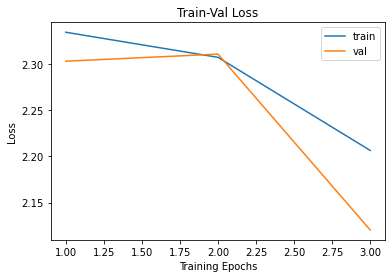

In [39]:
# 학습 결과를 시각화 해보자
num_epochs = params_train["num_epochs"]

# Epoch별 손실함수값 시각화 과정
plt.title("Train-Val Loss")
plt.plot(range(1, num_epochs+1), loss_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), loss_hist["val"], label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

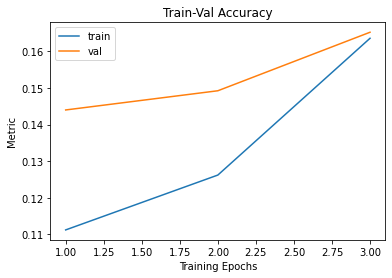

In [40]:
# Epoch별 정확도 시각화 과정
plt.title("Train-Val Accuracy")
plt.plot(range(1, num_epochs+1), metric_hist["train"], label="train")
plt.plot(range(1, num_epochs+1), metric_hist["val"], label="val")
plt.ylabel("Metric")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()